In [5]:
import pandas as pd
import numpy as np
from darts import TimeSeries
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from darts.models import LinearRegressionModel, RegressionModel
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from darts.metrics import mape, r2_score, mase, mse
import sklearn

In [6]:
# import yahoo finance data of 5 common stocks
import yfinance as yf
tickers = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'NFLX']
data = yf.download(tickers, start="2010-01-01", end="2020-12-31")
data = data['Adj Close'].dropna()

[*********************100%***********************]  5 of 5 completed


In [3]:
#data.info()
#data.head()
#data.plot()

In [7]:
# create TimeSeries object
ts = TimeSeries.from_dataframe(data, freq='D')

In [8]:
# compute monthly returns using pandas pct_change
returns = ts.pd_dataframe().pct_change().dropna()

# compute the cumulative monthly returns
cum_returns = (1 + returns).cumprod() - 1

# to use the Darts models, we need to convert the data to a Darts TimeSeries
cum_returns = TimeSeries.from_dataframe(df = cum_returns,time_col= 0, fill_missing_dates=True)

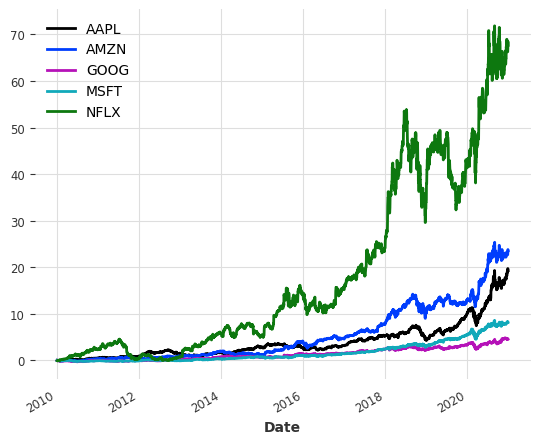

In [9]:
# plot the data
cum_returns.plot()

In [11]:
# split the data into train and test
train, test = cum_returns.split_after(0.7)

In [14]:
# implement two models: one standard linear regression and one with a polynomial feature

# linear regression
linear_regression = LinearRegressionModel(
    lags=1
    ) # output chunks standard is 1
linear_regression.fit(series=train)
linear_forecast = linear_regression.predict(len(test))

mape_lin = mape(test, linear_forecast)
mse_lin = mse(test, linear_forecast)
r2_lin = r2_score(test, linear_forecast)

In [13]:
# plot the results for the linear regression of the first stock
#plt.figure(figsize=(15,5))
#linear_forecast['AAPL'].plot(label=f'Linear Regression with MAPE: {mape_lin:.2f}, MSE: {mse_lin:.2f}, R2: {r2_lin:.2f}')
#cum_returns['AAPL'].plot(label='Actual')


In [15]:
# advanced model gradient boosting regressor with sklearn using random parameters
gbr = RegressionModel(
    lags=1,
    model=GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=1,
        random_state=0
    )
)
gbr.fit(series=train)
gbr_forecast = gbr.predict(len(test))

mape_gbr = mape(test, gbr_forecast)
mse_gbr = mse(test, gbr_forecast)
r2_gbr = r2_score(test, gbr_forecast)


In [16]:
# plot the results for the gradient boosting regressor of the first stock
#plt.figure(figsize=(15,5))
#gbr_forecast['AAPL'].plot(label= f'Gradient Boosting Regressor with MAPE: {mape_gbr:.2f}, MSE: {mse_gbr:.2f}, R2: {r2_gbr:.2f}')
#cum_returns['AAPL'].plot(label='Actual')

In [17]:
# hyperparameter tuning with gridsearch in darts for linear regression
hyperparameter_linear = {
    "lags": list(range(1,101))
}

In [19]:
tuning_linear = LinearRegressionModel.gridsearch(
    parameters= hyperparameter_linear,
    series= train, # The target series used as input and target for training.
    val_series= test,
    start= 0.1, # represents the starting point in the time index of series from which predictions will be made to evaluate the model
    metric= mape, # function that takes actual and prediction, and returns a float error value
    n_jobs= -1, # setting the parameter to -1 means using all the available cores
    verbose= True # whether to print progress
)

  0%|          | 0/100 [00:00<?, ?it/s]

In [20]:
# print the best hyperparameters
best_model_lin, best_params_lin = tuning_linear[0], tuning_linear[1]
best_model_lin.model_params

OrderedDict([('lags', 52),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('likelihood', None),
             ('quantiles', None),
             ('random_state', None),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [21]:
# perform the prediction with the best hyperparameters
best_model_lin.fit(train)
best_forecast_lin = best_model_lin.predict(len(test))

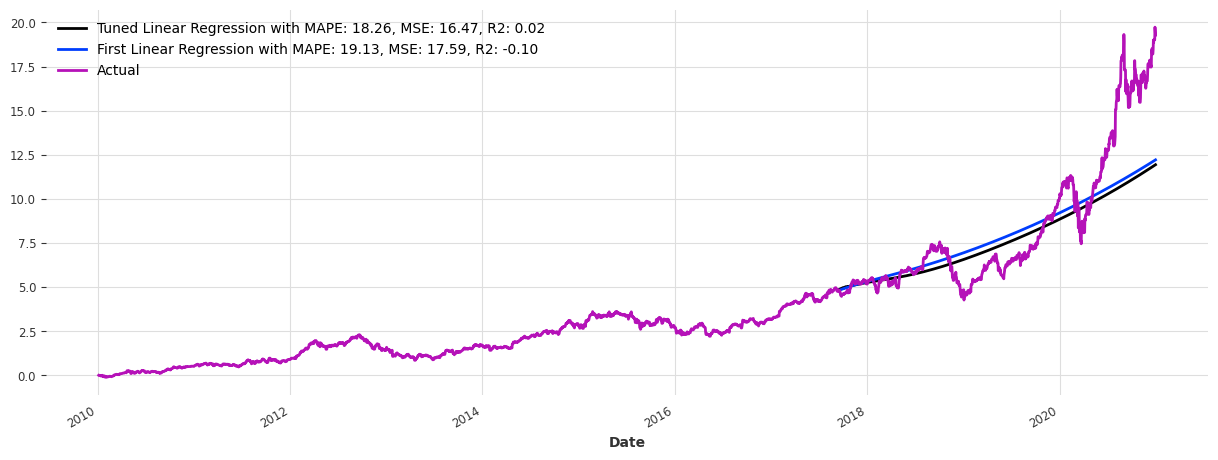

In [24]:
# plot both the old and the new forecast
plt.figure(figsize=(15,5))
mape_best = mape(test, best_forecast_lin)
mse_best = mse(test, best_forecast_lin)
r2_best = r2_score(test, best_forecast_lin)
best_forecast_lin['AAPL'].plot(label=f'Tuned Linear Regression with MAPE: {mape_best:.2f}, MSE: {mse_best:.2f}, R2: {r2_best:.2f}')
linear_forecast['AAPL'].plot(label=f'First Linear Regression with MAPE: {mape_lin:.2f}, MSE: {mse_lin:.2f}, R2: {r2_lin:.2f}')
cum_returns['AAPL'].plot(label='Actual')

In [64]:
hyperparameter_gradient_boosting = {
    "lags": list(range(1,51)),
    'model': [
        GradientBoostingRegressor(n_estimators=n, learning_rate=l, max_depth=m, random_state=0) 
        for n in range(1, 6) 
        for m in range(1, 6)
        for l in np.arange(0.1, 0.7, 0.1)
    ]
}

In [65]:
tuning_gbr = RegressionModel(
    lags= hyperparameter_gradient_boosting['lags'][0],
    model=GradientBoostingRegressor(n_estimators=0, learning_rate=0, max_depth=0, random_state=0)
)

In [67]:
# this took xx minutes
tuning_gradient_boosting = tuning_gbr.gridsearch(
    parameters= hyperparameter_gradient_boosting,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/7500 [00:00<?, ?it/s]

In [69]:
# print the best hyperparameters
best_model_gbr, best_params_gbr = tuning_gradient_boosting[0], tuning_gradient_boosting[1]
best_model_gbr.model_params

OrderedDict([('lags', 46),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model',
              GradientBoostingRegressor(learning_rate=0.6, max_depth=5, n_estimators=5,
                                        random_state=0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [70]:
best_model_gbr.fit(train)
best_forecast_gbr = best_model_gbr.predict(len(test))

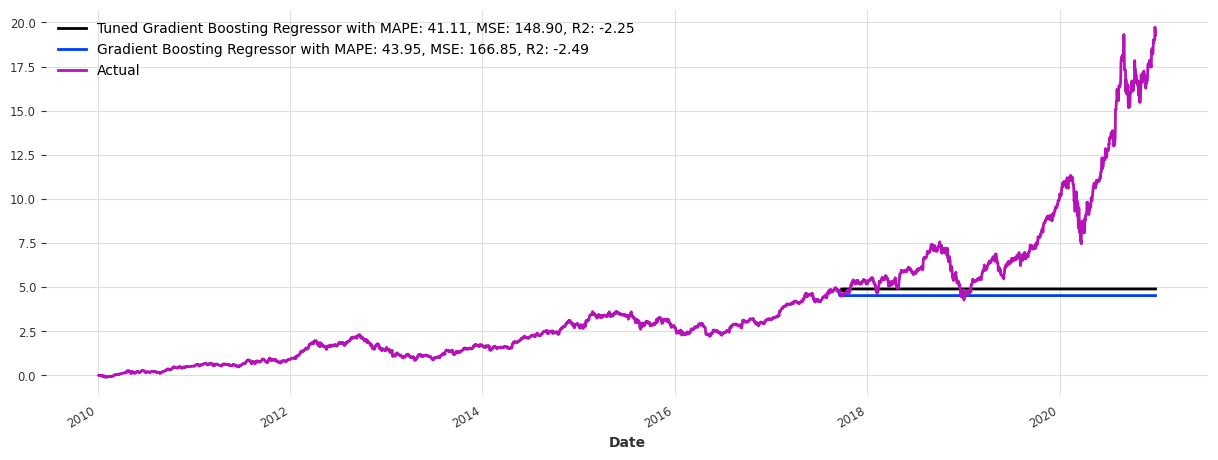

In [72]:
# plot both the old and the new forecast
plt.figure(figsize=(15,5))
mape_best = mape(test, best_forecast_gbr)
mse_best = mse(test, best_forecast_gbr)
r2_best = r2_score(test, best_forecast_gbr)
best_forecast_gbr['AAPL'].plot(label=f'Tuned Gradient Boosting Regressor with MAPE: {mape_best:.2f}, MSE: {mse_best:.2f}, R2: {r2_best:.2f}')
gbr_forecast['AAPL'].plot(label=f'Gradient Boosting Regressor with MAPE: {mape_gbr:.2f}, MSE: {mse_gbr:.2f}, R2: {r2_gbr:.2f}')
cum_returns['AAPL'].plot(label='Actual')

### Extra Trees

In [42]:
extra_tree = RegressionModel(
    lags=1,
    model=ExtraTreesRegressor(
        n_estimators=100,
        max_depth=1,
        random_state=0
    )
)
extra_tree.fit(series=train)
extra_tree_forecast = extra_tree.predict(len(test))

mape_extra_tree = mape(test, extra_tree_forecast)
mse_extra_tree = mse(test, extra_tree_forecast)
r2_extra_tree = r2_score(test, extra_tree_forecast)

In [30]:
hyperparameter_extra_tress = {
    "lags": list(range(1,51)),
    'model': [
        sklearn.ensemble.ExtraTreesRegressor(n_estimators=n, max_depth=m, min_samples_split=s, random_state=0) 
        for n in np.arange(1, 6, 1)
        for m in np.arange(1, 6, 1)
        for s in np.arange(2, 6, 1)
    ]
}

In [33]:
tuning_extr = RegressionModel(
    lags= hyperparameter_extra_tress['lags'][0],
    model=sklearn.ensemble.ExtraTreesRegressor(n_estimators=0, max_depth=0, min_samples_split=0, random_state=0)
)

In [36]:
# this took xx minutes
tuning_extra_trees = tuning_extr.gridsearch(
    parameters= hyperparameter_extra_tress,
    series= train,
    val_series= test,
    start= 0.1,
    metric= mape,
    n_jobs= -1,
    verbose= True
)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [37]:
# print the best hyperparameters
best_model_extr, best_params_extr = tuning_extra_trees[0], tuning_extra_trees[1]
best_model_extr.model_params

OrderedDict([('lags', 17),
             ('lags_past_covariates', None),
             ('lags_future_covariates', None),
             ('output_chunk_length', 1),
             ('add_encoders', None),
             ('model',
              ExtraTreesRegressor(max_depth=5, n_estimators=1, random_state=0)),
             ('multi_models', True),
             ('use_static_covariates', True)])

In [38]:
best_model_extr.fit(train)
best_forecast_extr = best_model_extr.predict(len(test))

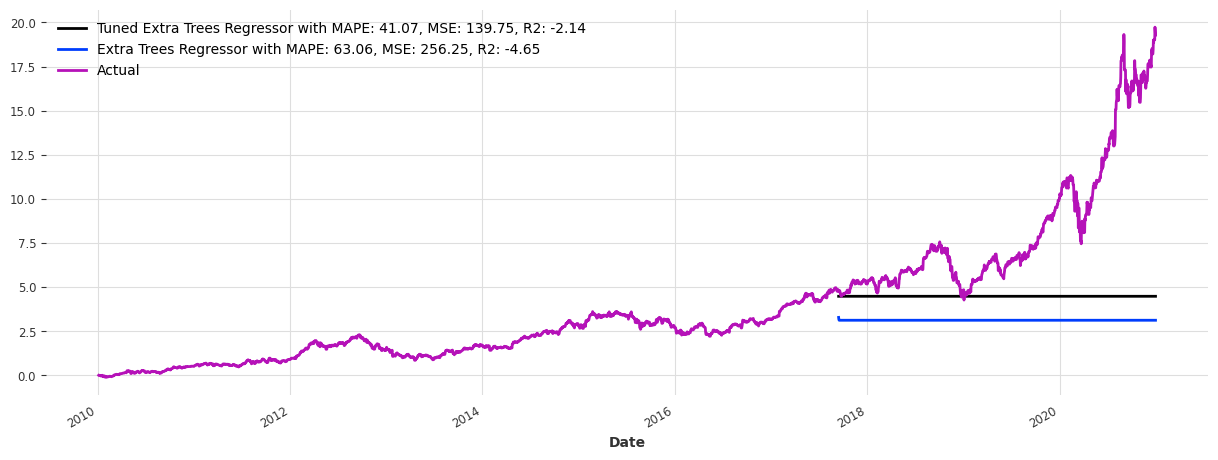

In [43]:
# plot both the old and the new forecast
plt.figure(figsize=(15,5))
mape_best = mape(test, best_forecast_extr)
mse_best = mse(test, best_forecast_extr)
r2_best = r2_score(test, best_forecast_extr)
best_forecast_extr['AAPL'].plot(label=f'Tuned Extra Trees Regressor with MAPE: {mape_best:.2f}, MSE: {mse_best:.2f}, R2: {r2_best:.2f}')
extra_tree_forecast['AAPL'].plot(label=f'Extra Trees Regressor with MAPE: {mape_extra_tree:.2f}, MSE: {mse_extra_tree:.2f}, R2: {r2_extra_tree:.2f}')
cum_returns['AAPL'].plot(label='Actual')